<a href="https://colab.research.google.com/github/anyaiyer/melanoma-detection/blob/main/Melanoma_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

[Fastai](https://www.fast.ai/) was used in creating this melanoma detection model.
Fastai is a deep learning libary that provides efficient ways to create neural networks and perform other machine learning tasks. 
You can read the fastai book [here](https://github.com/fastai/fastbook) (on Github), where you can explore this open source library.

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [5]:
from fastai import *

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
root_dir = "/content/gdrive/My Drive/Colab Notebooks/cancer_detection/"

In [8]:
import pandas as pd

In [9]:
label_info = pd.read_csv(f"{root_dir}/train.csv")
label_info.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [10]:
label_info['target'].value_counts() # dataset is very unbalanced

0    32542
1      584
Name: target, dtype: int64

## Data Preprocessing

In [11]:
def label_func(fname): # function grabs the label from the image name
    label =  label_info.loc[label_info['image_name'] == fname.name[:-4]]['target'].item()
    return label

The DataBlock API is used to create the DataLoaders class. The DataLoaders class stores DataLoaders objects and is used to create a training and validation set. 

In the DataBlock, we can specify the independent variable (ImageBlock or the images used for classifcation) and the dependent variable (Category Block or the labels). 
- get_items gets the independent variable, in this case the image files
- get_y gets the labels (taken from the label_func  function we wrote above)
- splitter: splits the data into a training and validation set
- we can do data augmentation with the aug_transforms method where we can specify certain actions that will be performed to the image

What is data augmentation? 

Data augmentation is a way to prevent overfitting and can also expand the dataset by performing different actions to the image. Some actions include rotating the image, zooming in/out, changing the lighting, warping the image, and performing vertical flips. 

In [12]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock), # independent & dependent variables
                   get_items = get_image_files, # gets the images
                   get_y     = label_func, # gets the labels
                   splitter  = RandomSplitter(valid_pct=0.1,seed=42), # 20% used for the validation set
                   batch_tfms=aug_transforms(mult=1.0, # data augmentation
                                             do_flip=True, 
                                             flip_vert=True,
                                             max_rotate=10.0,
                                             min_zoom=1.0,
                                             max_zoom=1.1,
                                             max_lighting=0.2, 
                                             max_warp=0.0,
                                             p_affine=0.0,
                                             p_lighting=0.0,
                                             xtra_tfms=None,
                                             size=None, 
                                             mode='bilinear',
                                             pad_mode='reflection',
                                             align_corners=True,
                                             batch=False, min_scale=1.0), 
                   item_tfms = Resize(224)) # resizing the image

In [13]:
path = Path("/content/gdrive/My Drive/Colab Notebooks/cancer_detection/train6") # file spath for the image

Tell fastai where the data is and where the images can be found.

In [14]:
dls = dblock.dataloaders(path)  
dls.bs = 32 # batch size

In [15]:
malig = 0
beg = 0
for fname in os.listdir(f"{root_dir}/train6"): # tells us how many malginant/benign images are in our file
  label =  label_info.loc[label_info['image_name'] == fname[:-4]]['target'].item()
  if label == 1: 
    malig = malig + 1
  else:
    beg =  beg + 1
  
print(f"malig = {malig} beg = {beg}")

malig = 533 beg = 648


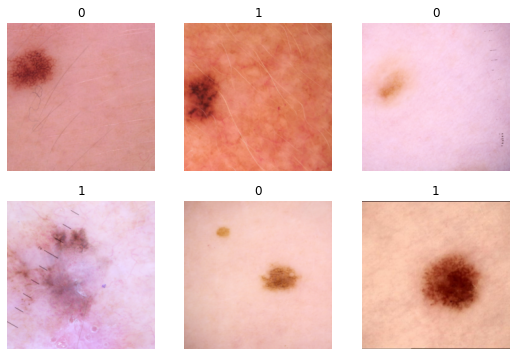

In [16]:
dls.show_batch(nrows=2, ncols=3) # data looks good 

In [17]:
len(dls.train_ds.splits[0]),len(dls.train_ds.splits[1]) # training and val split 
# 1063 images in training set, 118 images in val set

(1063, 118)

In [49]:
dls.c # 2 classes 

2

## Building/Training the Model

We now have all the data in our Dataloaders class. The data is also preprocessed and augmentated. We can build our fastai learner.

ResNet50 is the model architecture. [ResNet (residual neural network)](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) is a network architecture developed from the ImageNet dataset. ResNet utilizes skip connections which skip layers in the network and feeds that layer's output as input to the next layer. ResNets use skips that contain nonlinearities (like ReLU) as well as batch normalization. Batch normalization is a way to rescale layer inputs and can also reduce overfitting/generalization error. Overall, ResNets are great CNN architectures to use.

With fastai, we are using transfer learning. Transfer learning is the reuse of a pre-trained model on a new problem. We are not creating a ResNet model from scratch, and instead are using the pre-trained version. (ResNet is trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) database).

ResNet50 refers to 50 layers being used in the network. There is also ResNet18, ResNet34, ResNet101, ResNet110, and more. 

In [19]:
def accuracy(inp, targ, axis=-1): # accuracy function from fastai
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

When building the cnn_learner, we specify the following:
- what metrics we want to use
- our data in the DataLoaders class (dls)
- the model architecture (resnet50)

The cnn_learner automatically chooses a loss function in this case, [binary cross entropy loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). 

Then, we train the model by choosing the number of epochs as well as setting the learning rate. lr_find() chooses the best learning rate for the model, but I already performed a learning rate find prior to building this specific model (I performed it on an earlier version of the model). 

We freeze the intial layers to prevent the weights from being modified. learn.unfreeze() unfreezes the weights of the model so that they can get updated. 


In [ ]:
metrics = [accuracy,
           error_rate, 
           RocAucBinary(), Recall(), Precision()] # pass in metrics

learn = cnn_learner(dls, resnet50, metrics=metrics)
learn.load(f"{root_dir}/model_1")
learn.fit_one_cycle(4, lr_max=slice(1e-4,1e-3))
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,recall_score,precision_score,time
0,0.050365,0.797637,0.745763,0.254237,0.852580,0.727273,0.640000,12:40


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,recall_score,precision_score,time
0,0.050365,0.797637,0.745763,0.254237,0.852580,0.727273,0.640000,12:40
1,0.042896,0.936366,0.754237,0.245763,0.832924,0.727273,0.653061,12:13
2,0.072485,0.791935,0.762712,0.237288,0.837531,0.840909,0.637931,12:30
3,0.193607,0.795778,0.737288,0.262712,0.834152,0.772727,0.618182,12:40


In [ ]:
learn.fit_one_cycle(4, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,recall_score,precision_score,time
0,0.083160,0.811129,0.728814,0.271186,0.846130,0.704545,0.620000,15:52
1,0.058096,0.799473,0.737288,0.262712,0.844287,0.727273,0.627451,15:44
2,0.062593,0.825072,0.737288,0.262712,0.840295,0.727273,0.627451,15:41
3,0.057859,0.822485,0.728814,0.271186,0.839066,0.704545,0.620000,15:59


We save the model after training to prevent from retraining the model again. We can use this saved model to get predictions by loading the model for later use. 

In [20]:
#learn.save(f"{root_dir}/model_1") 
# save the model 

In [21]:
predictor = Path('/content/gdrive/My Drive/Colab Notebooks/cancer_detection/model_1.pth') # path of model

In [22]:
predictor = cnn_learner(dls, resnet50, metrics=metrics)
predictor.load(f"{root_dir}/model_1") # load model
# learn.export()
# path = Path()
# path.ls(file_exts='.pkl')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


## Improving the Model

We can improve upon our CNN model by changing the threshold. The goal is to maximize recall (the ability to predict false negatives). Changing the threshold can improve recall. 

In order to do this:

1) Create a test set -> let's see how our loaded model is performing.

2) Use a "for loop" to get predictions for each test sample.

3) Get the confusion matrix, precision, recall, and accuracy for each threshold number on the test set. This allows us to compare threshold values and find the best one. 

- lower thresholds maximize recall, while higher thresholds maximize precision

In [23]:
# create a test set
count = 0
test_sample = label_info.sample(80,random_state=6)
for row in label_info.iterrows():
  img = row[1]['image_name']
  entry = label_info.loc[label_info['image_name'] == img]
  val = entry['target'].item()
  if val == 1 :
    test_sample = test_sample.append(entry)
    if count > 20:
      break
    count = count +1 

In [24]:
test_sample.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
25463,ISIC_7727347,IP_8012985,male,35.0,torso,unknown,benign,0
15042,ISIC_4602691,IP_9042214,female,30.0,torso,unknown,benign,0
19592,ISIC_5950453,IP_1645936,female,65.0,lower extremity,unknown,benign,0
6717,ISIC_2106358,IP_2107993,female,70.0,torso,unknown,benign,0
722,ISIC_0319715,IP_0825081,male,80.0,upper extremity,unknown,benign,0


In [25]:
test_sample['target'].value_counts()
# 79 images are benign
# 23 images are malignant

0    79
1    23
Name: target, dtype: int64

In [26]:
preds = [] # predictions for each test sample
for row in test_sample.iterrows():
  img = row[1]['image_name']
  test_path = '/content/gdrive/My Drive/Colab Notebooks/cancer_detection/test1/' + img + '.jpg'
  result = predictor.predict(test_path)
  print(result)
  preds.append((row[1]['target'],result))

('0', tensor(0), tensor([0.6423, 0.3577]))


('0', tensor(0), tensor([9.9976e-01, 2.4008e-04]))


('0', tensor(0), tensor([0.9800, 0.0200]))


('0', tensor(0), tensor([0.5918, 0.4082]))


('0', tensor(0), tensor([0.8687, 0.1313]))


('0', tensor(0), tensor([0.9846, 0.0154]))


('0', tensor(0), tensor([0.8314, 0.1686]))


('1', tensor(1), tensor([0.3057, 0.6943]))


('0', tensor(0), tensor([0.9867, 0.0133]))


('1', tensor(1), tensor([0.4748, 0.5252]))


('0', tensor(0), tensor([9.9985e-01, 1.5056e-04]))


('1', tensor(1), tensor([0.0783, 0.9217]))


('0', tensor(0), tensor([9.9976e-01, 2.3610e-04]))


('1', tensor(1), tensor([0.4265, 0.5735]))


('0', tensor(0), tensor([0.9989, 0.0011]))


('0', tensor(0), tensor([0.5720, 0.4280]))


('0', tensor(0), tensor([0.7868, 0.2132]))


('0', tensor(0), tensor([0.9951, 0.0049]))


('0', tensor(0), tensor([9.9933e-01, 6.6831e-04]))


('0', tensor(0), tensor([0.9953, 0.0047]))


('0', tensor(0), tensor([0.9969, 0.0031]))


('0', tensor(0), tensor([0.6926, 0.3074]))


('1', tensor(1), tensor([0.0095, 0.9905]))


('0', tensor(0), tensor([9.9906e-01, 9.4321e-04]))


('0', tensor(0), tensor([0.6615, 0.3385]))


('0', tensor(0), tensor([0.9845, 0.0155]))


('0', tensor(0), tensor([0.7969, 0.2031]))


('1', tensor(1), tensor([0.3074, 0.6926]))


('0', tensor(0), tensor([0.9893, 0.0107]))


('0', tensor(0), tensor([0.9097, 0.0903]))


('0', tensor(0), tensor([0.9891, 0.0109]))


('0', tensor(0), tensor([0.9917, 0.0083]))


('0', tensor(0), tensor([9.9973e-01, 2.7363e-04]))


('0', tensor(0), tensor([9.9954e-01, 4.5710e-04]))


('0', tensor(0), tensor([0.9981, 0.0019]))


('0', tensor(0), tensor([0.9327, 0.0673]))


('0', tensor(0), tensor([0.9827, 0.0173]))


('0', tensor(0), tensor([0.9892, 0.0108]))


('0', tensor(0), tensor([0.9887, 0.0113]))


('0', tensor(0), tensor([9.9962e-01, 3.7699e-04]))


('1', tensor(1), tensor([2.7057e-05, 9.9997e-01]))


('1', tensor(1), tensor([0.0232, 0.9768]))


('0', tensor(0), tensor([9.9995e-01, 5.1845e-05]))


('0', tensor(0), tensor([0.9981, 0.0019]))


('0', tensor(0), tensor([9.9916e-01, 8.4017e-04]))


('1', tensor(1), tensor([0.3211, 0.6789]))


('0', tensor(0), tensor([0.9976, 0.0024]))


('0', tensor(0), tensor([0.7306, 0.2694]))


('0', tensor(0), tensor([0.9977, 0.0023]))


('0', tensor(0), tensor([0.8333, 0.1667]))


('0', tensor(0), tensor([0.5153, 0.4847]))


('0', tensor(0), tensor([0.9967, 0.0033]))


('0', tensor(0), tensor([0.9745, 0.0255]))


('0', tensor(0), tensor([0.7785, 0.2215]))


('1', tensor(1), tensor([0.3891, 0.6109]))


('1', tensor(1), tensor([0.4114, 0.5886]))


('0', tensor(0), tensor([9.9988e-01, 1.2232e-04]))


('0', tensor(0), tensor([0.9271, 0.0729]))


('1', tensor(1), tensor([1.3298e-05, 9.9999e-01]))


('0', tensor(0), tensor([0.9932, 0.0068]))


('1', tensor(1), tensor([0.3282, 0.6718]))


('0', tensor(0), tensor([0.9962, 0.0038]))


('0', tensor(0), tensor([0.8974, 0.1026]))


('1', tensor(1), tensor([5.8348e-04, 9.9942e-01]))


('1', tensor(1), tensor([0.0368, 0.9632]))


('0', tensor(0), tensor([9.9992e-01, 8.4112e-05]))


('0', tensor(0), tensor([0.9342, 0.0658]))


('0', tensor(0), tensor([0.9990, 0.0010]))


('0', tensor(0), tensor([9.9985e-01, 1.5245e-04]))


('0', tensor(0), tensor([0.9857, 0.0143]))


('0', tensor(0), tensor([0.9501, 0.0499]))


('0', tensor(0), tensor([0.7935, 0.2065]))


('0', tensor(0), tensor([0.8951, 0.1049]))


('0', tensor(0), tensor([0.9375, 0.0625]))


('1', tensor(1), tensor([0.1404, 0.8596]))


('1', tensor(1), tensor([0.1018, 0.8982]))


('0', tensor(0), tensor([0.9981, 0.0019]))


('0', tensor(0), tensor([0.8985, 0.1015]))


('0', tensor(0), tensor([0.9705, 0.0295]))


('0', tensor(0), tensor([9.9953e-01, 4.6525e-04]))


('0', tensor(0), tensor([0.5459, 0.4541]))


('1', tensor(1), tensor([0.0028, 0.9972]))


('1', tensor(1), tensor([0.0238, 0.9762]))


('1', tensor(1), tensor([0.0013, 0.9987]))


('1', tensor(1), tensor([0.3138, 0.6862]))


('1', tensor(1), tensor([0.0164, 0.9836]))


('1', tensor(1), tensor([0.0181, 0.9819]))


('1', tensor(1), tensor([0.4287, 0.5713]))


('1', tensor(1), tensor([0.0441, 0.9559]))


('1', tensor(1), tensor([0.0233, 0.9767]))


('1', tensor(1), tensor([0.0267, 0.9733]))


('1', tensor(1), tensor([0.4932, 0.5068]))


('1', tensor(1), tensor([0.3203, 0.6797]))


('1', tensor(1), tensor([0.1264, 0.8736]))


('1', tensor(1), tensor([0.0417, 0.9583]))


('1', tensor(1), tensor([0.0028, 0.9972]))


('1', tensor(1), tensor([0.0087, 0.9913]))


('1', tensor(1), tensor([0.0325, 0.9675]))


('1', tensor(1), tensor([0.0022, 0.9978]))


('1', tensor(1), tensor([1.7296e-04, 9.9983e-01]))


('1', tensor(1), tensor([1.8824e-04, 9.9981e-01]))


('1', tensor(1), tensor([8.8793e-05, 9.9991e-01]))


In [38]:
preds # we can visually compare the model's predictions to the ground truth

[(0, ('0', tensor(0), tensor([0.6423, 0.3577]))),
 (0, ('0', tensor(0), tensor([9.9976e-01, 2.4008e-04]))),
 (0, ('0', tensor(0), tensor([0.9800, 0.0200]))),
 (0, ('0', tensor(0), tensor([0.5918, 0.4082]))),
 (0, ('0', tensor(0), tensor([0.8687, 0.1313]))),
 (0, ('0', tensor(0), tensor([0.9846, 0.0154]))),
 (0, ('0', tensor(0), tensor([0.8314, 0.1686]))),
 (0, ('1', tensor(1), tensor([0.3057, 0.6943]))),
 (0, ('0', tensor(0), tensor([0.9867, 0.0133]))),
 (0, ('1', tensor(1), tensor([0.4748, 0.5252]))),
 (0, ('0', tensor(0), tensor([9.9985e-01, 1.5056e-04]))),
 (0, ('1', tensor(1), tensor([0.0783, 0.9217]))),
 (0, ('0', tensor(0), tensor([9.9976e-01, 2.3610e-04]))),
 (0, ('1', tensor(1), tensor([0.4265, 0.5735]))),
 (0, ('0', tensor(0), tensor([0.9989, 0.0011]))),
 (0, ('0', tensor(0), tensor([0.5720, 0.4280]))),
 (0, ('0', tensor(0), tensor([0.7868, 0.2132]))),
 (0, ('0', tensor(0), tensor([0.9951, 0.0049]))),
 (0, ('0', tensor(0), tensor([9.9933e-01, 6.6831e-04]))),
 (0, ('0', tensor(

In [39]:
index = 3
thd = .3
def get_pred(index, thd): 
  predicted_one = preds[index][1][2][1].item()
  predicted_value = 0;
  if predicted_one > thd:
    predicted_value = 1
  else:
    predicted_value = 0
  return predicted_value

preds[index][0]

def getConfusion(actual_value,predicted_value):
  if actual_value == 1 :
    if predicted_value == 1 :
      return 0 #TP
    else:
      return 1 #FN
  else:
    if predicted_value == 1 :
      return 2 #FP
    else:
      return 3 #TN

def getConfusionMatrix(thd):
  confusion_mat = { 0:0,1:0,2:0,3:0}
  for index,pred in enumerate(preds):
    pred_val = get_pred(index,thd)
    actu_val = preds[index][0]
    result = getConfusion(actu_val,pred_val)
    confusion_mat[result] = confusion_mat[result] + 1
  return confusion_mat

def getRecall(conf):
  return conf[0]/(conf[0]+conf[1])
def getPrecision(conf):
  return conf[0]/(conf[0]+conf[2])
def getAcc(conf):
  return (conf[0]+conf[3])/(conf[0]+conf[1]+conf[2]+conf[3])

recalls = []
precs = []
accs = []
for thd in range(1,10):
  conf = getConfusionMatrix(0.1*thd)
  recall = getRecall(conf)
  prec = getPrecision(conf)
  acc = getAcc(conf)
  recalls.append(recall)
  precs.append(prec)
  accs.append(acc)
  print(f"{conf}, recall = {recall} precision = {prec} accuracy = {acc}")

{0: 23, 1: 0, 2: 33, 3: 46}, recall = 1.0 precision = 0.4107142857142857 accuracy = 0.6764705882352942
{0: 23, 1: 0, 2: 27, 3: 52}, recall = 1.0 precision = 0.46 accuracy = 0.7352941176470589
{0: 23, 1: 0, 2: 22, 3: 57}, recall = 1.0 precision = 0.5111111111111111 accuracy = 0.7843137254901961
{0: 23, 1: 0, 2: 19, 3: 60}, recall = 1.0 precision = 0.5476190476190477 accuracy = 0.8137254901960784
{0: 22, 1: 1, 2: 16, 3: 63}, recall = 0.9565217391304348 precision = 0.5789473684210527 accuracy = 0.8333333333333334
{0: 20, 1: 3, 2: 13, 3: 66}, recall = 0.8695652173913043 precision = 0.6060606060606061 accuracy = 0.8431372549019608
{0: 17, 1: 6, 2: 9, 3: 70}, recall = 0.7391304347826086 precision = 0.6538461538461539 accuracy = 0.8529411764705882
{0: 17, 1: 6, 2: 9, 3: 70}, recall = 0.7391304347826086 precision = 0.6538461538461539 accuracy = 0.8529411764705882
{0: 16, 1: 7, 2: 7, 3: 72}, recall = 0.6956521739130435 precision = 0.6956521739130435 accuracy = 0.8627450980392157


In [40]:
precs

[0.4107142857142857,
 0.46,
 0.5111111111111111,
 0.5476190476190477,
 0.5789473684210527,
 0.6060606060606061,
 0.6538461538461539,
 0.6538461538461539,
 0.6956521739130435]

In [41]:
recalls

[1.0,
 1.0,
 1.0,
 1.0,
 0.9565217391304348,
 0.8695652173913043,
 0.7391304347826086,
 0.7391304347826086,
 0.6956521739130435]

In [42]:
accs

[0.6764705882352942,
 0.7352941176470589,
 0.7843137254901961,
 0.8137254901960784,
 0.8333333333333334,
 0.8431372549019608,
 0.8529411764705882,
 0.8529411764705882,
 0.8627450980392157]

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [44]:
sns.set_style('darkgrid')

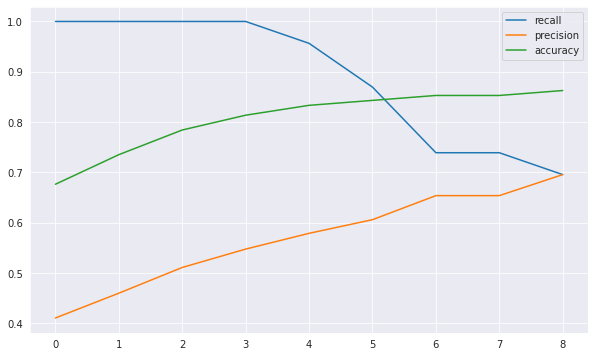

In [45]:
plt.figure(figsize=(10,6))
sns.lineplot(data=recalls)
sns.lineplot(data=precs)
sns.lineplot(data=accs)
plt.legend(labels=['recall', 'precision', 'accuracy'])

# goal: maximize recall
# best threshold: 0.4 - 0.5

In [46]:
def get_pred(index, thd): # get predictions function
  # best thresholds are 0.5 and 0.4 (want to minimize recall while also having a bit of a balance between accuracy and precision)
  predicted_one = preds[index][1][2][1].item()
  predicted_value = 0;
  if predicted_one > thd:
    predicted_value = 1
  else:
    predicted_value = 0
  return predicted_value

In [47]:
get_pred(3,0.4)

1

## Creating an Interactive Application

Our model can easily be put to use with ipython widgets. All code from here is from the [Fastbook - Chapter 2 (Production)](https://github.com/fastai/fastbook). 


 

In [27]:
from ipywidgets import Button, HBox, VBox
import ipywidgets as widgets
from IPython.display import display

In [28]:
btn_upload = widgets.FileUpload(layout=widgets.Layout(width='%10', height='40px'),
    style= {'button_color': 'lightblue'})
btn_upload

FileUpload(value={}, description='Upload', layout=Layout(height='40px', width='%10'), style=ButtonStyle(button…

In [29]:
btn_upload = SimpleNamespace(data = ['/content/gdrive/My Drive/Colab Notebooks/cancer_detection/test1/ISIC_3609081.jpg'])

In [30]:
img = PILImage.create(btn_upload.data[-1])

In [31]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [32]:
pred,pred_idx,probs = predictor.predict(img)

In [33]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: 0; Probability: 0.9893')

In [34]:
btn_run = widgets.Button(description='Classify', layout=widgets.Layout(width='%10', height='40px'),style= {'button_color': 'lightgreen'})
btn_run

Button(description='Classify', layout=Layout(height='40px', width='%10'), style=ButtonStyle(button_color='ligh…

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = predictor.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [36]:
btn_upload = widgets.FileUpload(layout=widgets.Layout(width='%10', height='40px'),
    style= {'button_color': 'lightblue'})

In [37]:
VBox([widgets.Label('Select your image'), 
      btn_upload, btn_run, out_pl, lbl_pred])
# model predicted benign (this image is from an unused test set)